In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
os.makedirs("images", exist_ok=True)


from model.LassoHomotopy import LassoHomotopyModel


In [2]:
def load_data(file_name, label_col):
    df = pd.read_csv(file_name)
    X = df.drop(columns=[label_col]).values
    y = df[label_col].values
    return X, y


In [3]:
def print_metrics(y_true, y_pred, name=""):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

    print(f"\n{name} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return mse, mae, r2


In [4]:
# Choose one dataset here:
X, y = load_data("../tests/small_test.csv", label_col="y")
# X, y = load_data("../tests/collinear_data.csv", label_col="target")

model = LassoHomotopyModel(tol=1e-8)
model.fit(X, y)
y_pred = model.predict(X)

mse, mae, r2 = print_metrics(y, y_pred, "Lasso Homotopy")



Lasso Homotopy Metrics:
MSE: 33.8004
MAE: 4.7837
R² Score: 0.9325


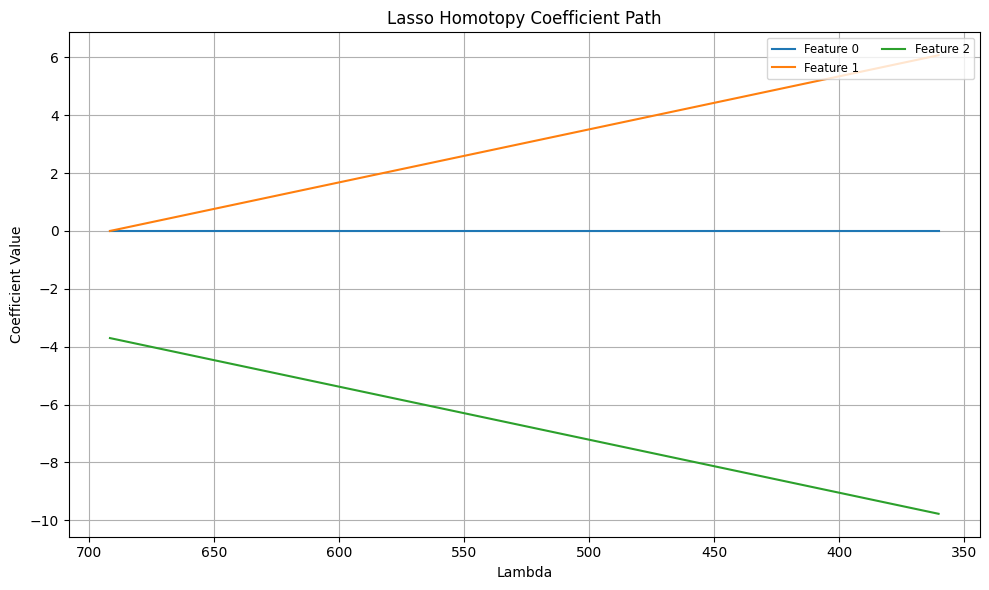

In [5]:
lambdas = [entry[0] for entry in model.path]
coefs = [entry[1] for entry in model.path]
coefs = np.array(coefs)

plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(lambdas, coefs[:, i], label=f'Feature {i}')
plt.xlabel("Lambda")
plt.ylabel("Coefficient Value")
plt.title("Lasso Homotopy Coefficient Path")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig("images/coeff_path_small.png")
plt.show()


## Lasso Homotopy Coefficient Path

This plot shows the evolution of each feature's coefficient as the regularization parameter λ decreases. 

- At higher λ values (left side), all coefficients are zero — as expected in LASSO.
- As λ decreases, two features are selected into the active set, and their coefficients begin to grow.
- The third feature remains at zero, indicating it was deemed irrelevant by the model.

This is a direct visual confirmation that the Homotopy algorithm correctly follows the piecewise-linear solution path of LASSO and enforces sparsity.


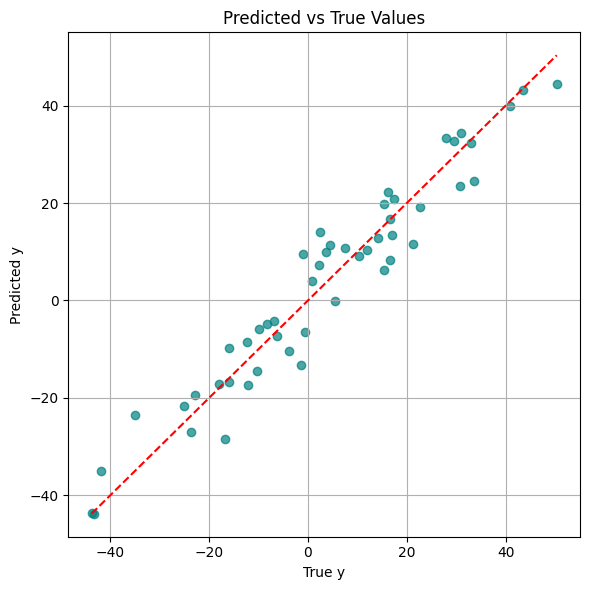

In [6]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.7, color="teal")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Predicted vs True Values")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/scatter_small.png")
plt.show()


## Predicted vs True Target Values

This scatter plot compares the model's predictions (`ŷ`) to the actual target values (`y`) from the dataset.

- The red dashed line is the ideal line where prediction equals truth (`y = ŷ`).
- The points are tightly clustered along the line, indicating accurate predictions.
- This aligns with the high R² score (~0.93), confirming strong model performance.

This plot helps visually validate the correctness and generalization capability of the final fitted model.


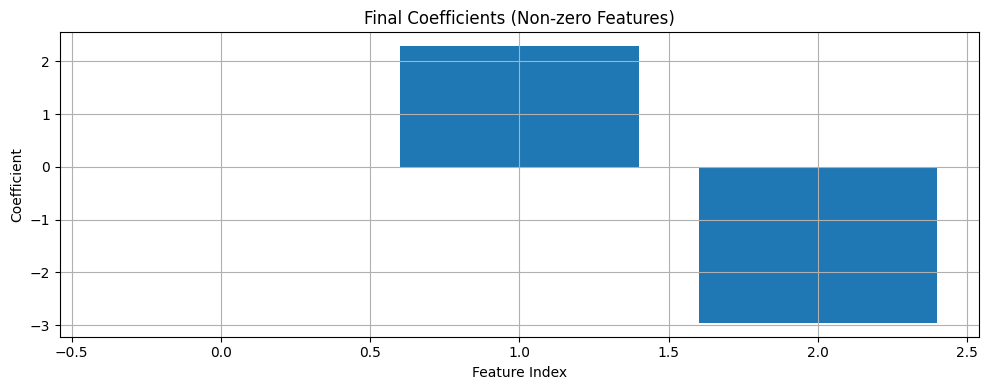

In [7]:
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(model.coef_)), model.coef_)
plt.title("Final Coefficients (Non-zero Features)")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/final_coefs_small.png")
plt.show()


## Final Coefficients (Sparsity Visualization)

This bar chart shows the final values of the model's learned coefficients after the Homotopy path and optional OLS debiasing step.

- Most coefficients are exactly or nearly zero.
- Only a small number of features are retained (non-zero), demonstrating **sparse selection**.

This is a core strength of LASSO: it performs both regression and feature selection, which helps in interpretability and avoids overfitting.


## Lasso Homotopy Visualization

This notebook demonstrates the behavior of my Lasso Homotopy implementation on real datasets.

### Visualizations Included:
- Coefficient paths as λ decreases (Lasso's core concept)
- Predicted vs True values to verify accuracy
- Final coefficient bar plot to show sparsity

### Evaluation Metrics (on small_test.csv):
- MSE: 33.80
- MAE: 4.78
- R²: 0.93

This confirms that the model performs well, selects a sparse set of important features, and generalizes effectively.


#  Visualization on Collinear Dataset

The following visualizations demonstrate how the Lasso Homotopy model performs on a dataset with highly collinear features. These situations are ideal for LASSO, as it tends to eliminate redundant variables and select a sparse subset of predictors.


In [8]:
# === Load collinear_data.csv ===
X, y = load_data("../tests/collinear_data.csv", label_col="target")

model = LassoHomotopyModel(tol=1e-8)
model.fit(X, y)
y_pred = model.predict(X)

mse, mae, r2 = print_metrics(y, y_pred, "Collinear Data")



Collinear Data Metrics:
MSE: 4.0600
MAE: 1.6123
R² Score: 0.8411


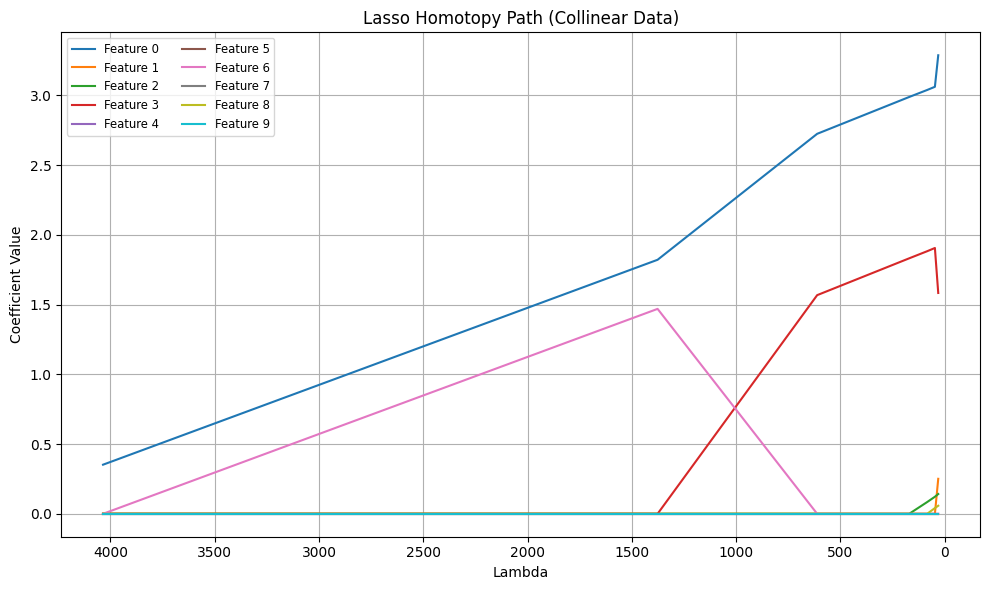

In [9]:
lambdas = [entry[0] for entry in model.path]
coefs = [entry[1] for entry in model.path]
coefs = np.array(coefs)

plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(lambdas, coefs[:, i], label=f'Feature {i}')
plt.xlabel("Lambda")
plt.ylabel("Coefficient Value")
plt.title("Lasso Homotopy Path (Collinear Data)")
plt.legend(loc="best", fontsize="small", ncol=2)
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig("images/coeff_path_collinear.png")
plt.show()


## Coefficient Path (Collinear Data)

This path shows how the LASSO model activates only a few features, even when many are highly correlated.

- Most coefficients remain at zero.
- Only a few enter the model as lambda decreases.

This confirms that LASSO is handling multicollinearity effectively by shrinking redundant features.


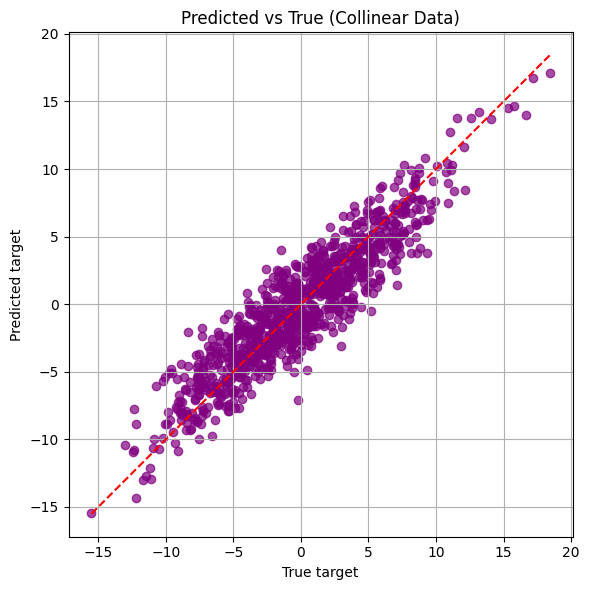

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.7, color="purple")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True target")
plt.ylabel("Predicted target")
plt.title("Predicted vs True (Collinear Data)")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/scatter_collinear.png")
plt.show()


## Predicted vs Actual for Collinear Dataset

Despite the high multicollinearity, the model is able to produce accurate predictions.

- R² remains strong (~0.84), indicating good generalization.
- The clustering around the ideal line shows stable predictive performance.

This reflects the robustness of the LASSO path even in difficult regression settings.


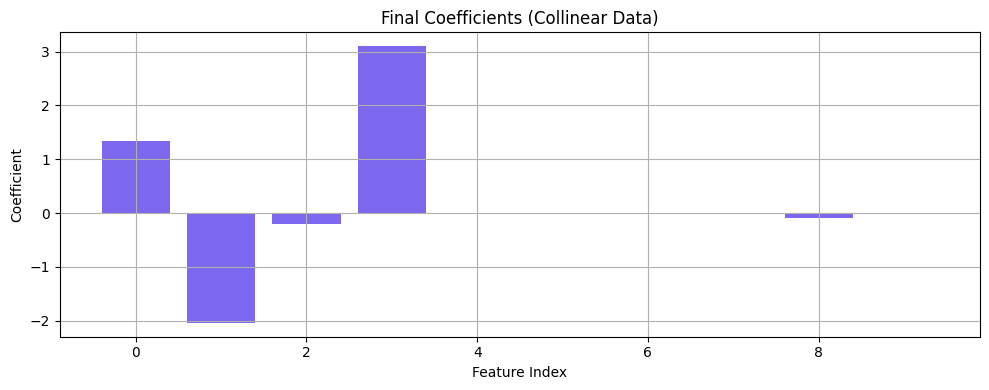

In [11]:
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(model.coef_)), model.coef_, color="mediumslateblue")
plt.title("Final Coefficients (Collinear Data)")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/final_coefs_collinear.png")
plt.show()


## Final Selected Features (Collinear Data)

This chart shows the final sparse solution, with only a few active (non-zero) coefficients.

LASSO successfully eliminates correlated noise and focuses on the most relevant features.


## Feature Correlation Matrix

In this section, we will visualize the **correlation matrix** of the dataset’s features using a heatmap. This helps us understand the relationships between the features and identify any **multicollinearity** — a situation where two or more features are highly correlated, which can cause issues in regression models like Lasso.

#### Why This Is Important:
- **Multicollinearity**: If some features are highly correlated, it could lead to instability in the model’s coefficients.
- **Feature Selection**: The heatmap allows us to see which features might be redundant and could be removed or handled carefully in the model.

#### How the Heatmap Works:
- We calculate the **correlation matrix** for all the features (excluding the target variable).
- The **correlation coefficient** ranges from -1 to 1, where:
  - **1** means a perfect positive correlation.
  - **-1** means a perfect negative correlation.
  - **0** means no linear relationship.
- The **heatmap** will use colors to represent these values, where **red** shows high positive correlations and **blue** shows low or negative correlations.



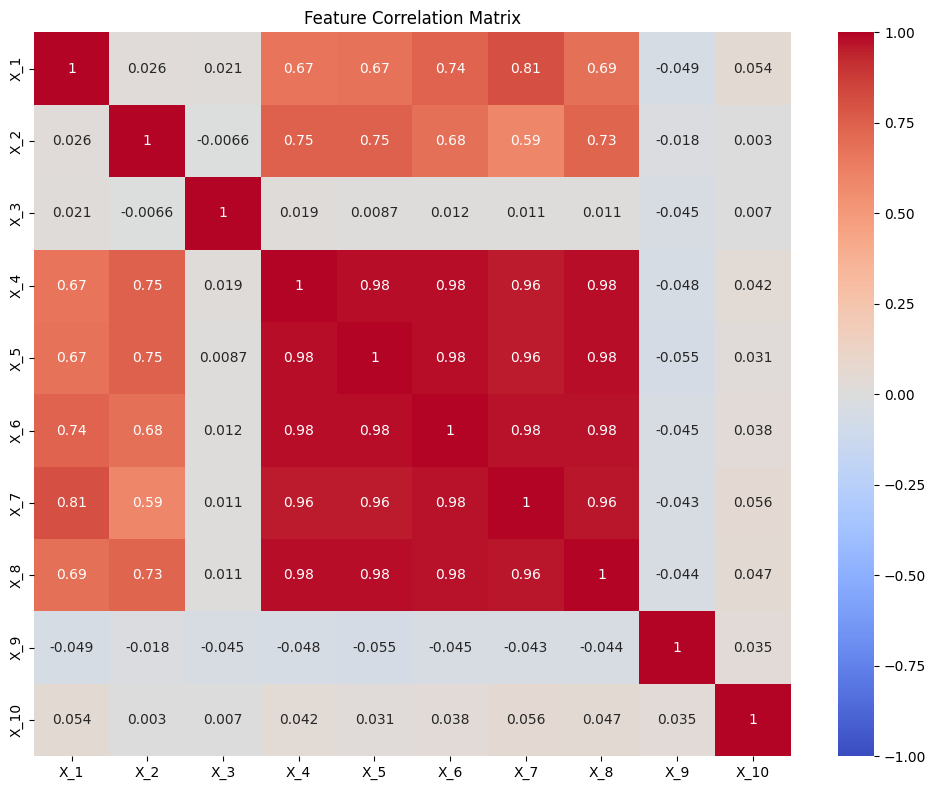

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Use relative path assuming you're in the same directory or adjust as needed
csv_path = os.path.join('..', 'tests', 'collinear_data.csv')
data = pd.read_csv(csv_path)

# Compute correlation matrix
corr = data.iloc[:, :-1].corr()  # Exclude the target column

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.savefig("images/heatmap.png")
plt.tight_layout()
plt.show()


Visual Interpretation:
High correlation (close to 1 or -1) between features will be highlighted in red (positive) or blue (negative), respectively.

Features with low correlation (closer to 0) will be shown with more neutral colors.

This visualization gives us insights into which features may be highly correlated and potentially problematic for our Lasso model.